# 1. モジュールインポート

In [2]:
import pandas as pd
import glob
import os
import datetime
from tqdm.auto import tqdm
from modules.constants import Master
from modules.constants import LocalPaths
from modules.constants import HorseResultsCols
from modules.constants import ResultsCols
from modules import preparing
from modules import preprocessing
from modules import training
from modules import simulation
from modules import policies
%load_ext autoreload

標準的な土日競馬開催時の運用スケジュールを以下の表の通り。

|曜日|時刻|内容|実行する main.ipynb の項番|備考|
|:-:|:--|:--|:--|:--|
|月|||||
|火|||||
|水|16:30過ぎ|先週土日の馬の過去成績ページ確定<BR>（netkeiba.comﾌﾟﾚﾐｱｻｰﾋﾞｽのﾀｲﾑ指数・ﾚｰｽ分析・注目馬 ﾚｰｽ後の短評情報確定）|2. データ取得 ～ 5. シミュレーション|3日間開催の場合も、水曜日|
|木|||||
|金|10:05過ぎ<BR>19:25過ぎ|土曜の出馬表確定<BR>土曜の天候・馬場状態更新|6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|土|09:00～17:00<BR>10:05過ぎ<BR>19:25過ぎ| レース時刻<BR>日曜の出馬表確定<BR>日曜の天候・馬場状態更新|6.3. レース直前データ処理（当日レース予想）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|日|09:00～17:00|レース時刻|6.3. レース直前データ処理（当日レース予想）||

# 2. データ取得

## 2.1. レースID取得
例として、2020年のレースデータを取得する場合を考える

In [4]:
%autoreload

In [7]:
#開催日取得。to_の月は含まないので注意。
kaisai_date_2020 = preparing.scrape_kaisai_date(from_="2010-01-01", to_="2024-05-22")
len(kaisai_date_2020)

getting race date from 2010-01-01 to 2024-05-22


  0%|          | 0/172 [00:00<?, ?it/s]

1551

In [8]:
# 開催日からレースIDの取得
race_id_list = preparing.scrape_race_id_list(kaisai_date_2020)
len(race_id_list)

getting race_id_list


  0%|          | 0/1551 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100105
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100109
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100110
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100111
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100116
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100117
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100123
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100124
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100130
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100131
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100206
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100207
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100213
scraping: ht

49564

## 2.2. /race/ディレクトリのデータ取得

In [9]:
#https://db.netkeiba.com/race/のhtml(binファイル)をスクレイピングして保存
html_files_race = preparing.scrape_html_race(race_id_list, skip=True)
html_files_race[:5]

  0%|          | 0/49564 [00:00<?, ?it/s]

race_id 201106010604 skipped. This page is not valid.
race_id 201408020304 skipped. This page is not valid.
race_id 201405010404 skipped. This page is not valid.
race_id 201405010508 skipped. This page is not valid.
race_id 201805010304 skipped. This page is not valid.
race_id 202006010101 skipped
race_id 202006010102 skipped
race_id 202006010103 skipped
race_id 202006010104 skipped
race_id 202006010105 skipped
race_id 202006010106 skipped
race_id 202006010107 skipped
race_id 202006010108 skipped
race_id 202006010109 skipped
race_id 202006010110 skipped
race_id 202006010111 skipped
race_id 202006010112 skipped
race_id 202008010101 skipped
race_id 202008010102 skipped
race_id 202008010103 skipped
race_id 202008010104 skipped
race_id 202008010105 skipped
race_id 202008010106 skipped
race_id 202008010107 skipped
race_id 202008010108 skipped
race_id 202008010109 skipped
race_id 202008010110 skipped
race_id 202008010111 skipped
race_id 202008010112 skipped
race_id 202006010201 skipped
race_

['/home/hinata/code/HinataMikami/keibaAI-v2-main/data/html/race/201006010101.bin',
 '/home/hinata/code/HinataMikami/keibaAI-v2-main/data/html/race/201006010102.bin',
 '/home/hinata/code/HinataMikami/keibaAI-v2-main/data/html/race/201006010103.bin',
 '/home/hinata/code/HinataMikami/keibaAI-v2-main/data/html/race/201006010104.bin',
 '/home/hinata/code/HinataMikami/keibaAI-v2-main/data/html/race/201006010105.bin']

In [10]:
results_new = preparing.get_rawdata_results(html_files_race) #レース結果テーブルの作成
race_info_new = preparing.get_rawdata_info(html_files_race) #レース情報テーブルの作成
return_tables_new = preparing.get_rawdata_return(html_files_race) #払戻テーブルの作成

preparing raw results table


  0%|          | 0/34535 [00:00<?, ?it/s]

preparing raw race_info table


  0%|          | 0/34535 [00:00<?, ?it/s]

preparing raw return table


  0%|          | 0/34535 [00:00<?, ?it/s]

In [11]:
# テーブルの更新。元々のテーブルが存在しない場合は、新たに作成される。
preparing.update_rawdata(filepath=LocalPaths.RAW_RESULTS_PATH, new_df=results_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RACE_INFO_PATH, new_df=race_info_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RETURN_TABLES_PATH, new_df=return_tables_new)

## 2.3. /horse/ディレクトリのデータ取得

In [12]:
%autoreload

In [14]:
horse_id_list = results_new['horse_id'].unique()
#htmlをスクレイピング
#すでにスクレイピングしてある馬をスキップしたい場合はskip=Trueにする
#すでにスクレイピングしてある馬でも、新たに出走した成績を更新したい場合はskip=Falseにする
html_files_horse = preparing.scrape_html_horse_with_master(
    horse_id_list, skip=True
    )

scraping


  0%|          | 0/53280 [00:00<?, ?it/s]

horse_id 2007102719 skipped
horse_id 2007104474 skipped
horse_id 2007104533 skipped
horse_id 2007101891 skipped
horse_id 2007106506 skipped
horse_id 2007100239 skipped
horse_id 2007101725 skipped
horse_id 2007101308 skipped
horse_id 2007105515 skipped
horse_id 2007105022 skipped
horse_id 2007104590 skipped
horse_id 2007101832 skipped
horse_id 2007106483 skipped
horse_id 2007105314 skipped
horse_id 2007105979 skipped
horse_id 2007104211 skipped
horse_id 2007102771 skipped
horse_id 2007102232 skipped
horse_id 2007103403 skipped
horse_id 2007109164 skipped
horse_id 2007102006 skipped
horse_id 2007104937 skipped
horse_id 2007103482 skipped
horse_id 2007102898 skipped
horse_id 2007101473 skipped
horse_id 2007102601 skipped
horse_id 2007103711 skipped
horse_id 2007104292 skipped
horse_id 2007104680 skipped
horse_id 2007100843 skipped
horse_id 2007104454 skipped
horse_id 2007103847 skipped
horse_id 2007104973 skipped
horse_id 2007101560 skipped
horse_id 2007110103 skipped
horse_id 2007106491 

In [15]:
#追加で新たにスクレイピングされた数
len(html_files_horse)

31730

In [22]:
### scrape関数を実行せずに、保存してあるhtmlのパスを取得する場合、以下を実行 ###

"""target_date = '2022-06-25' #スクレイピングした日付を指定
# マスタの読み込み
update_master = pd.read_csv(
    LocalPaths.MASTER_RAW_HORSE_RESULTS_PATH,
    dtype=object
    )
# target_dateにスクレイピングしたhorse_idに絞り込む
filter = pd.to_datetime(update_master['updated_at']).dt.strftime('%Y-%m-%d') == target_date
horse_id_list = update_master[filter]['horse_id']

# binファイルのパスを取得
html_files_horse = []
for horse_id in tqdm(horse_id_list):
    file = glob.glob(os.path.join(LocalPaths.HTML_HORSE_DIR, horse_id+'*.bin'))[0]
    html_files_horse.append(file)
html_files_horse[:5]"""

  0%|          | 0/11561 [00:00<?, ?it/s]

['/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2017101445.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2017109028.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2016100106.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2015104412.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2016105305.bin']

In [16]:
# 馬の基本情報テーブルの作成
horse_info_new = preparing.get_rawdata_horse_info(html_files_horse)

preparing raw horse_info table


  0%|          | 0/31730 [00:00<?, ?it/s]

In [17]:
# 馬の基本情報テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_new)

In [18]:
#　馬の過去成績テーブルの作成
horse_results_new = preparing.get_rawdata_horse_results(html_files_horse)

preparing raw horse_results table


  0%|          | 0/31730 [00:00<?, ?it/s]

In [19]:
# テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_new)

## 2.4. /ped/ディレクトリのデータ取得

In [24]:
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True) #htmlをスクレイピング

  0%|          | 0/53280 [00:00<?, ?it/s]

horse_id 2007102719 skipped
horse_id 2007104474 skipped
horse_id 2007104533 skipped
horse_id 2007101891 skipped
horse_id 2007106506 skipped
horse_id 2007100239 skipped
horse_id 2007101725 skipped
horse_id 2007101308 skipped
horse_id 2007105515 skipped
horse_id 2007105022 skipped
horse_id 2007104590 skipped
horse_id 2007101832 skipped
horse_id 2007106483 skipped
horse_id 2007105314 skipped
horse_id 2007105979 skipped
horse_id 2007104211 skipped
horse_id 2007102771 skipped
horse_id 2007102232 skipped
horse_id 2007103403 skipped
horse_id 2007109164 skipped
horse_id 2007102006 skipped
horse_id 2007104937 skipped
horse_id 2007103482 skipped
horse_id 2007102898 skipped
horse_id 2007101473 skipped
horse_id 2007102601 skipped
horse_id 2007103711 skipped
horse_id 2007104292 skipped
horse_id 2007104680 skipped
horse_id 2007100843 skipped
horse_id 2007104454 skipped
horse_id 2007103847 skipped
horse_id 2007104973 skipped
horse_id 2007101560 skipped
horse_id 2007110103 skipped
horse_id 2007106491 

In [2]:
peds_new = preparing.get_rawdata_peds(html_files_peds) #血統テーブルの作成
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_new) #テーブルの更新

NameError: name 'html_files_peds' is not defined

# 3. データ加工

In [3]:
#モジュールを更新した際、notebookに反映させるために使用。
#すでにインポートしてあるモジュールの更新が反映される。
%autoreload

In [4]:
#前処理
results_processor = preprocessing.ResultsProcessor(filepath=LocalPaths.RAW_RESULTS_PATH)
race_info_processor = preprocessing.RaceInfoProcessor(filepath=LocalPaths.RAW_RACE_INFO_PATH)
return_processor = preprocessing.ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

              着順  枠番  馬番         馬名  性齢    斤量    騎手     タイム     着差     単勝  \
202006010101   1   4   7  オイデヤスダイジン  牝3  54.0  伊藤工真  1:13.3    NaN    3.6   
202006010101   2   1   1      グルアーブ  牝3  54.0  柴田善臣  1:13.3     クビ   17.2   
202006010101   3   2   3  トーレスデルパイネ  牝3  54.0  岩部純二  1:13.7  2.1/2  199.0   
202006010101   4   3   6      デュープス  牝3  54.0  武士沢友  1:13.8     クビ   50.4   
202006010101   5   6  12    ディヴィニティ  牝3  54.0  マーフィ  1:13.8     クビ    1.6   
...           ..  ..  ..        ...  ..   ...   ...     ...    ...    ...   
201909050912  12   5   9   キラーコンテンツ  牡5  57.0  北村友一  1:10.4    3/4   11.5   
201909050912  13   2   4   スカイパッション  牝7  55.0  藤懸貴志  1:10.5    1/2  294.0   
201909050912  14   5  10   ラフィングマッチ  牡4  57.0  太宰啓介  1:10.7  1.1/4  114.8   
201909050912  15   7  14    フェルトベルク  牝5  55.0  団野大成  1:11.0  1.3/4  115.2   
201909050912   0   1   2   クインズチャパラ  牝4  55.0  藤岡佑介     NaN    NaN    ---   

                人気      馬体重       調教師    horse_id jockey_id trainer_id  \
2

/home/hinata/code/HinataMikami/keibaAI-v2-main/modules/preprocessing/_horse_results_processor.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[Cols.PRIZE].fillna(0, inplace=True)


馬の過去成績を集計しつつ、前処理の済みの全てのテーブルをマージする処理

In [5]:
# ターゲットエンコーディング時に「馬の成績」として扱う項目
TARGET_COLS = [
        HorseResultsCols.RANK,
        HorseResultsCols.PRIZE,
        HorseResultsCols.RANK_DIFF, 
        'first_corner',
        'final_corner',
        'first_to_rank',
        'first_to_final',
        'final_to_rank',
        'time_seconds'
        ]
# horse_id列と共に、ターゲットエンコーディングの対象にする列
GROUP_COLS = [
        'course_len',
        'race_type',
        HorseResultsCols.PLACE
        ]

data_merger = preprocessing.DataMerger(
        results_processor,
        race_info_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
)
# 処理実行
data_merger.merge()

separating horse results by date


  0%|          | 0/1551 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1551 [00:00<?, ?it/s]

In [6]:
#カテゴリ変数の処理
feature_enginnering = preprocessing.FeatureEngineering(data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

/home/hinata/code/HinataMikami/keibaAI-v2-main/modules/preprocessing/_feature_engineering.py:102: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_target_master = pd.concat([target_master, new_target]).set_index(target_col)['encoded_id']
/home/hinata/code/HinataMikami/keibaAI-v2-main/modules/preprocessing/_feature_engineering.py:102: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_target_master = pd.concat([target_master, new_target]).set_index(target_col)['encoded_id']
/home/hinata/code/HinataMikami/keibaAI-v2-main/modules/preprocessing/_feature_engi

In [7]:
#保存
#tmpは一時保存用のディレクトリ
feature_enginnering.featured_data.to_pickle('data/tmp/featured_data_20240525.pickle')

# 4. 学習

In [4]:
keiba_ai = training.KeibaAIFactory.create(feature_enginnering.featured_data) #モデル作成
keiba_ai.train_with_tuning() #パラメータチューニングをして学習

NameError: name 'training' is not defined

In [6]:
#特徴量の重要度
keiba_ai.feature_importance()

,features,importance
4,jockey_id,123
184,age_days,108
10,n_horses,77
8,体重,75
183,interval,71
120,breeder_id,62
13,賞金_5R,62
103,賞金_race_type_allR,52
31,賞金_race_type_5R,49
14,着差_5R,42


In [7]:
#ハイパーパラメータの確認
keiba_ai.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 100,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_pre_filter': False,
 'lambda_l1': 4.602348963946269e-06,
 'lambda_l2': 8.389123215314243,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0}

In [26]:
#チューニングしないで学習
#keiba_ai.train_without_tuning()

AUC: 0.826(train), 0.648(test)


In [8]:
#モデル保存。models/(実行した日付)/(version_name).pickleに、モデルとデータセットが保存される。
training.KeibaAIFactory.save(keiba_ai, version_name='basemodel_2018_2021')

In [9]:
#モデルロード
keiba_ai = training.KeibaAIFactory.load('models/20240525/basemodel_20101-20245.pickle')

: 

In [ ]:
keiba_ai.set_params(keiba_ai.get_params())

# 5. シミュレーション

In [9]:
%autoreload

In [5]:
#シミュレーターに馬券をセット
simulator = simulation.Simulator(return_processor)

NameError: name 'return_processor' is not defined

In [ ]:
# スコアテーブルを取得
score_table = keiba_ai.calc_score(keiba_ai.datasets.X_test, policies.StdScorePolicy)

## 5.1. 単一threshold

### 5.1.1 単勝馬券

In [17]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyTansho, # 賭け方の方針
                threshold=threshold #「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
#シミュレーション結果も、models/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/tansho.pickle')

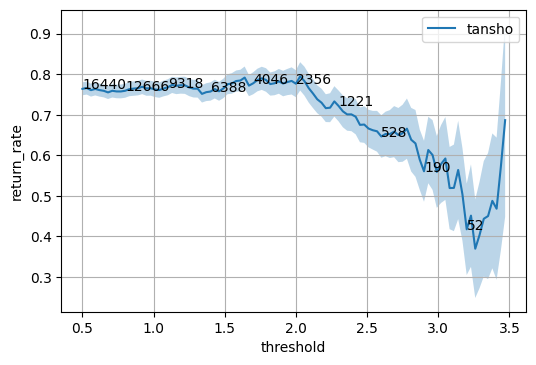

In [19]:
#回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='tansho')

### 5.1.2 複勝馬券

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyFukusho, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/fukusho.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='fukusho')

### 5.1.3 馬連BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmarenBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/umarenbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umarenbox')

### 5.1.4 馬単BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmatanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/umatanbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umatanbox')

### 5.1.5 ワイドBOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyWideBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/widebox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='widebox')

### 5.1.6 三連複BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrenpukuBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/sanrenpukubox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrenpukubox')

### 5.1.7 三連単BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrentanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/sanrentanbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrentanbox')

## 5.2. 複数馬券
未実装

## 5.3. 複数threshold
未実装だが、以下のようなコードになる予定。

In [274]:
T1_RANGE = [2.5, 3.5]
MIN_T2 = 1
N_SAMPLES = 10

returns = {}
#「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
idx = 0
for i in tqdm(range(N_SAMPLES)):
    #T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold1 = T1_RANGE[1] * i / N_SAMPLES + T1_RANGE[0] * (1-(i/N_SAMPLES))
    for j in range(N_SAMPLES):
        #MIN_T2からthreshold1までをN_SAMPLES等分
        threshold2 = threshold1 * j / N_SAMPLES + MIN_T2 * (1-(j/N_SAMPLES))
        try:
            #print(threshold1, threshold2)
            #賭ける馬券を決定
            actions = keiba_ai.decide_action(
                    score_table, # スコアテーブル
                    policies.BetPolicyTanshoFukusho, # 賭け方の方針(未実装)
                    threshold1=threshold1, #「馬の勝ちやすさスコア」の閾値
                    threshold2=threshold2
                    )
            returns[idx] = simulator.calc_returns(actions)
            idx += 1
        except Exception as e:
            print(e)
            break
returns_df = pd.DataFrame.from_dict(returns, orient='index')

  0%|          | 0/10 [00:00<?, ?it/s]

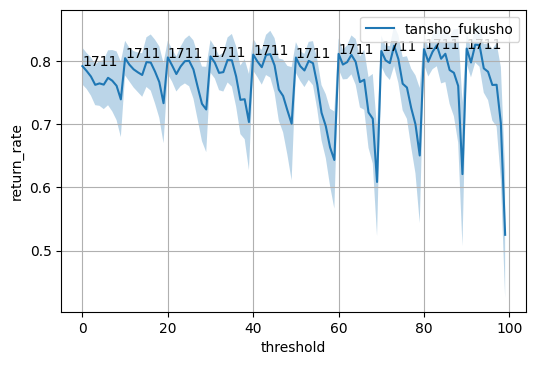

In [273]:
simulation.plot_single_threshold(returns_df.reset_index(), 100, label='tansho_fukusho')

# 6. 当日の予想
例として2022年1月8日のレースを実際に予想する場合を考える。  
https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108

## 6.1. 前日準備

In [20]:
%autoreload

In [21]:
race_id_list = preparing.scrape_race_id_list(['20220108']) #レースidを取得
len(race_id_list)

getting race_id_list


  0%|          | 0/1 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108


24

In [22]:
#出走するhorse_idの取得
horse_id_list = preparing.scrape_horse_id_list(race_id_list)
len(horse_id_list)

sraping horse_id_list


  0%|          | 0/24 [00:00<?, ?it/s]

361

In [ ]:
#horseページのhtmlをスクレイピング
#直近レースが更新されている可能性があるので、skip=Falseにして上書きする
html_files_horse = preparing.scrape_html_horse_with_master(horse_id_list, skip=False)

In [ ]:
#horse_infoテーブルの更新
horse_info_20220108 = preparing.get_rawdata_horse_info(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_20220108)

In [ ]:
#horse_resultsテーブルの更新
horse_results_20220108 = preparing.get_rawdata_horse_results(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_20220108)

In [ ]:
#pedsテーブルの更新
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True)
peds_20220108 = preparing.get_rawdata_peds(html_files_peds)
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_20220108)

In [27]:
#processorの更新
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

In [32]:
#モデルの準備
keiba_ai = training.KeibaAIFactory.load('models/20220626/basemodel_2018_2021.pickle')

## 6.2. 前日全レース予想

In [ ]:
%autoreload

In [ ]:
# 前日全レース予想用のレースidとレース発走時刻を取得
target_race_id_list, target_race_time_list = preparing.scrape_race_id_race_time_list('20221001')
print(len(target_race_id_list))
print(len(target_race_time_list))
yesterday = True

In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
today = '2022/10/01'

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 前日予想の場合
    if yesterday:
        # 前日予想の場合、馬体重を0（0）に補正
        pd2 = pd.read_pickle(filepath)
        pd2[ResultsCols.WEIGHT_AND_DIFF] = '0(0)'
        # 前日予想の場合、天候と馬場状態が公開されていない場合はこちらを有効にする
        #pd2['weather'] = '晴'
        #pd2['ground_state'] = '良'
        pd2.to_pickle(filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

## 6.3. レース直前データ処理（当日レース予想）

In [28]:
%autoreload

In [ ]:
# 馬体重の発表されたレースID、レース時刻を取得（レース当日用）
target_race_id_list, target_race_time_list = preparing.create_active_race_id_list()
print((target_race_id_list))
print((target_race_time_list))

In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
#today = '2022/10/01'
today = datetime.datetime.now().date().strftime('%Y/%m/%d')

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]
    #df_tmp['race_type'] tmp.iat[0, 12]
    #df_tmp['around'] 13
    #df_tmp['weather'] 14
    #df_tmp['ground_state'] 15
    #df_tmp['race_class']16

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

## 6.4. レース直前データ処理（旧方式）

In [ ]:
filepath = 'data/tmp/shutuba.pickle' #一時的に出馬表を保存するパスを指定
preparing.scrape_shutuba_table(race_id_list[0], '2022/1/8', filepath) #馬体重が発表されたら、出馬表を取得
shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath) #出馬表の加工

In [30]:
#テーブルのマージ
shutuba_data_merger = preprocessing.ShutubaDataMerger(
    shutuba_table_processor,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS
)

shutuba_data_merger.merge()

separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
#特徴量エンジニアリング
feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

In [32]:
#予測
X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)
keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False)

,馬番,単勝,score
202206010201,5,4.7,1.972623
202206010201,3,4.3,1.698477
202206010201,15,4.5,1.292167
202206010201,4,5.7,0.754306
202206010201,11,5.4,0.706008
202206010201,6,16.9,0.401887
202206010201,16,14.2,-0.070303
202206010201,1,26.7,-0.260754
202206010201,13,29.8,-0.300251
202206010201,9,101.3,-0.481400
